In [3]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from seiz_eeg.dataset import EEGDataset

# The data

We model *segments* of brain activity, which correspond to windows of a longer *session* of EEG recording.

These segments, and their labels, are described in the `segments.parquet` files, which can be directly loaded with `pandas`.

In [ ]:
# You might need to change this according to where you store the data folder
# Inside your data folder, you should have the following structure:
# data
# ├── train
# │   ├── signals/
# │   ├── segments.parquet
# │-- test
#     ├── signals/
#     ├── segments.parquet

data_path = "../data"

DATA_ROOT = Path(data_path)
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

# Split the dataset by the 'patient' column
patients = clips_tr['signals_path'].unique()
train_patients, val_patients = train_test_split(patients, test_size=0.2, random_state=42)

# Create training and validation datasets
train_clips = clips_tr[clips_tr['signals_path'].isin(train_patients)]
val_clips = clips_tr[clips_tr['signals_path'].isin(val_patients)]

## Loading the signals

For convenience, the `EEGDataset class` provides functionality for loading each segment and its label as `numpy` arrays.

You can provide an optional `signal_transform` function to preprocess the signals. In the example below, we have two bandpass filtering functions, which extract frequencies between 0.5Hz and 30Hz which are used in seizure analysis literature:

The `EEGDataset` class also allows to load all data in memory, instead of reading it from disk at every iteration. If your compute allows it, you can use `prefetch=True`.

In [5]:
bp_filter = signal.butter(4, (0.5, 30), btype="bandpass", output="sos", fs=250)


def time_filtering(x: np.ndarray) -> np.ndarray:
    """Filter signal in the time domain"""
    return signal.sosfiltfilt(bp_filter, x, axis=0).copy()


def fft_filtering(x: np.ndarray) -> np.ndarray:
    """Compute FFT and only keep"""
    x = np.abs(np.fft.fft(x, axis=0))
    x = np.log(np.where(x > 1e-8, x, 1e-8))

    win_len = x.shape[0]
    # Only frequencies b/w 0.5 and 30Hz
    return x[int(0.5 * win_len // 250) : 30 * win_len // 250]

## Compatibility with PyTorch

The `EEGDataset` class is compatible with [pytorch datasets and dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allow you to load batched data.

In [6]:
# Dependences
import os
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm

In [7]:
def seed_everything(seed: int):
    # Python random module
    random.seed(seed)
    # Numpy random module
    np.random.seed(seed)
    # Torch random seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.

    # Set PYTHONHASHSEED environment variable for hash-based operations
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Ensure deterministic behavior in cudnn (may slow down your training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1)

In [8]:
# Usage:
train_dataset = EEGDataset(
    train_clips,
    signals_root=DATA_ROOT / "train",
    signal_transform=fft_filtering,
    prefetch=True,
)

val_dataset = EEGDataset(
    val_clips,
    signals_root=DATA_ROOT / "train",
    signal_transform=fft_filtering,
    prefetch=True,
)

In [9]:
from torch.utils.data import Sampler
from collections import defaultdict
import numpy as np

class PatientBatchSampler(Sampler):
    def __init__(self, clips_df):
        # Group indices by patient
        self.patient_to_indices = defaultdict(list)
        for idx, row in clips_df.reset_index().iterrows():
            patient_id = row['signals_path']  # Adjust column name if needed
            self.patient_to_indices[patient_id].append(idx)

        # Precompute position pairs and corresponding triplets
        self.triplet_batches = []
        for patient_id, indices in self.patient_to_indices.items():
            n = len(indices)
            for i in range(n):
                if n == 1:
                    triplet = [indices[0], indices[0], indices[0]]
                elif i == 0:
                    triplet = [indices[1], indices[0], indices[1]]
                elif i == n - 1:
                    triplet = [indices[-2], indices[-1], indices[-2]]
                else:
                    triplet = [indices[i - 1], indices[i], indices[i + 1]]
                self.triplet_batches.append(triplet)

    def __iter__(self):
        shuffled_batches = np.random.permutation(self.triplet_batches)
        for batch in shuffled_batches:
            yield batch

    def __len__(self):
        return len(self.triplet_batches)

train_sampler = PatientBatchSampler(train_clips)
val_sampler = PatientBatchSampler(val_clips)

loader_tr = DataLoader(
    dataset=train_dataset,
    batch_sampler=train_sampler,
)

loader_val = DataLoader(
    dataset=val_dataset,
    batch_sampler=val_sampler,
)

In [10]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Bidirectional LSTM model for sequential data

In this section, we train a bidirectional lstm model with an mlp for the sequence classification.

In [11]:
class BiLSTM(nn.Module):
    def __init__(self, input_dim=19, hidden_dim=64, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim, 
            hidden_dim, 
            num_layers, 
            batch_first=True, 
            dropout=dropout, 
            bidirectional=True  # Enable bidirectional LSTM
        )
        # Multiply hidden_dim by 6: 2 for bidirectional, 3 for first, last, and mean
        self.fc1 = nn.Linear(hidden_dim * 6, hidden_dim)  # First linear layer
        self.relu = nn.ReLU()  # ReLU activation

    def forward(self, x):
        """
        x shape: [batch_size, seq_len, input_dim]
        """
        out, (h_n, c_n) = self.lstm(x)  # out shape: [batch_size, seq_len, hidden_dim * 2]
        
        # Extract the first and last time steps
        first_timestep = out[:, 0, :]  # [batch_size, hidden_dim * 2]
        last_timestep = out[:, -1, :]  # [batch_size, hidden_dim * 2]
        
        # Compute the mean across the sequence dimension
        mean_timestep = out.mean(dim=1)  # [batch_size, hidden_dim * 2]
        
        # Concatenate the first, last, and mean time steps
        combined = torch.cat((first_timestep, last_timestep, mean_timestep), dim=1)  # [batch_size, hidden_dim * 6]
        
        # Pass the combined features through the MLP
        x = self.fc1(combined)  # [batch_size, hidden_dim * 3]
        x = self.relu(x)  # Apply ReLU activation
        
        return x

In [12]:
class BiLSTMCombined(nn.Module):
    def __init__(self, input_dim=19, hidden_dim=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.base_lstm = BiLSTM(input_dim, hidden_dim, num_layers, dropout)
        # self.final_lstm = nn.LSTM(
        #     input_size=hidden_dim, 
        #     hidden_size=hidden_dim, 
        #     num_layers=1,
        #     batch_first=True,
        #     bidirectional=True  # Enable bidirectional LSTM
        # )
        self.fc1 = nn.Linear(3*hidden_dim, 1)  # First linear layer
        

    def forward(self, x):
        """
        x shape: [batch_size, 3, seq_len, input_dim]
        """
        batch_size = x.shape[0]

        # Merge batch and triplet dims → [batch_size * 3, seq_len, input_dim]
        x_reshaped = x.view(batch_size * 3, x.shape[2], x.shape[3])

        # Process with base LSTM
        base_outputs = self.base_lstm(x_reshaped)  # [batch_size * 3, hidden_dim]

        # Reshape back to [batch_size, 3, hidden_dim]
        base_outputs = base_outputs.view(batch_size, 3 * base_outputs.shape[-1])

        # Apply FC layer → [batch_size, 1]
        logits = self.fc1(base_outputs).squeeze(-1)  # [batch_size]

        return logits

In [17]:
model = BiLSTMCombined(input_dim=19, hidden_dim=64, num_layers=2, dropout=0.3).to(device)
class_weight = 4
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([class_weight]).to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [18]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Training loop
num_epochs = 100
train_losses = []
val_losses = []
val_f1_scores = []
val_precision_scores = []
val_recall_scores = []

batch_size = 512
total = 0
len_tr = len(loader_tr)
len_val = len(loader_val)
x = []
y = []

for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    running_loss = 0.0
    x = []
    y = []
    total = 0

    for x_batch, y_batch in loader_tr:
        # Move data to GPU (if available)
        x_batch = x_batch.float().to(device)
        y_batch = y_batch[1].float().to(device)

        x.append(x_batch)
        y.append(y_batch)
        total += 1
        if total%batch_size == 0:
            x_batch = torch.stack(x, dim=0)
            y_batch = torch.stack(y, dim=0)
            x = []
            y = []
        else:
            continue

        # Forward pass
        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(loader_tr) * batch_size
    train_losses.append(avg_loss)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    all_labels = []
    all_preds = []
    x = []
    y = []
    total = 0

    with torch.no_grad():
        for x_val, y_val in loader_val:
            # Move data to GPU (if available)
            x_val = x_val.float().to(device)  # [batch_size, seq_len, input_dim]
            y_val = y_val[1].float().to(device)  # [batch_size, 1]

            x.append(x_val)
            y.append(y_val)
            total += 1
            if total%batch_size == 0 or total == len(loader_val):
                x_val = torch.stack(x, dim=0)
                y_val = torch.stack(y, dim=0)
                x = []
                y = []
            else:
                continue

            # Forward pass
            val_logits = model(x_val)
            val_preds = (val_logits > 0).int()  # Convert probabilities to binary predictions

            # Collect all labels and predictions
            all_labels.extend(y_val.cpu().numpy())
            all_preds.extend(val_preds.cpu().numpy())

            # Compute validation loss
            val_loss = criterion(val_logits, y_val)
            val_running_loss += val_loss.item()

    avg_val_loss = val_running_loss / len(loader_val) * batch_size
    val_losses.append(avg_val_loss)

    # Compute metrics for validation data
    all_labels = np.array(all_labels).flatten()
    all_preds = np.array(all_preds).flatten()
    val_f1 = f1_score(all_labels, all_preds, average='macro')
    val_precision = precision_score(all_labels, all_preds, average='macro')
    val_recall = recall_score(all_labels, all_preds, average='macro')
    val_f1_scores.append(val_f1)
    val_precision_scores.append(val_precision)
    val_recall_scores.append(val_recall)

print(f"Validation F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

Training: 100%|███████████████████████████████████████████████████████████████████| 100/100 [13:06<00:00,  7.87s/it]

Validation F1: 0.7773, Precision: 0.7599, Recall: 0.8015


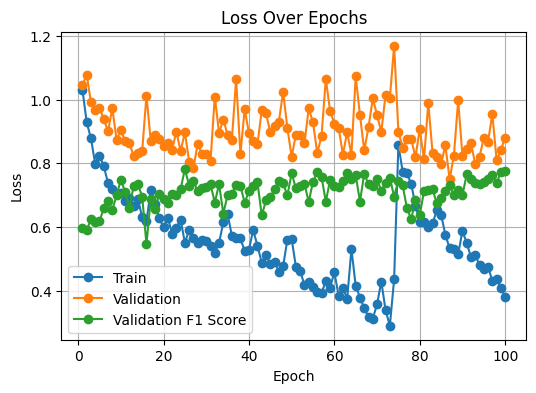

In [19]:
# Plot the training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), train_losses, marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, marker="o")
plt.plot(range(1, num_epochs + 1), val_f1_scores, marker="o")
plt.title("Loss Over Epochs")
plt.legend(["Train", "Validation", "Validation F1 Score"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Submission

In [16]:
data_path = "../data"

DATA_ROOT = Path(data_path)
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

dataset_tr = EEGDataset(
    clips_tr,
    signals_root=DATA_ROOT / "train",
    signal_transform=fft_filtering,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

loader_tr = DataLoader(dataset_tr, batch_sampler=train_sampler)

FileNotFoundError: [Errno 2] No such file or directory: '../data/train/segments.parquet'

In [ ]:
test_clips = pd.read_parquet(DATA_ROOT / "test/segments.parquet")

In [ ]:
model = BiLSTMCombined(input_dim=19, hidden_dim=64, num_layers=2, dropout=0.3).to(device)
class_weight = 4
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([class_weight]).to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Training loop
num_epochs = 100
train_losses = []

batch_size = 256
total = 0
len_tr = len(loader_tr)
x = []
y = []

for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    running_loss = 0.0
    x = []
    y = []
    total = 0

    for x_batch, y_batch in loader_tr:
        # Move data to GPU (if available)
        x_batch = x_batch.float().to(device)
        y_batch = y_batch[1].float().to(device)

        x.append(x_batch)
        y.append(y_batch)
        total += 1
        if total%batch_size == 0:
            x_batch = torch.stack(x, dim=0)
            y_batch = torch.stack(y, dim=0)
            x = []
            y = []
        else:
            continue

        # Forward pass
        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(loader_tr) * batch_size
    train_losses.append(avg_loss)

Training:   0%|                                                                  | 0/100 [00:00<?, ?it/s]

Training:   6%|███▍                                                      | 6/100 [00:27<07:13,  4.61s/it]


KeyboardInterrupt: 

In [ ]:
# Create test dataset
dataset_te = EEGDataset(
    test_clips,  # Your test clips variable
    signals_root=DATA_ROOT
    / "test",  # Update this path if your test signals are stored elsewhere
    signal_transform=fft_filtering,  # You can change or remove the signal_transform as needed
    prefetch=True,  # Set to False if prefetching causes memory issues on your compute environment
    return_id=True,  # Return the id of each sample instead of the label
)

In [ ]:
# Create DataLoader for the test dataset
test_sampler = PatientBatchSampler(test_clips)
loader_te = DataLoader(dataset_te, batch_sampler=test_sampler)

In [ ]:
# Generate the submission file for Kaggle

# Set the model to evaluation mode
model.eval()

# Lists to store sample IDs and predictions
all_predictions = []
all_ids = []

batch_size = 512
total = 0
len_te = len(loader_te)
x = []
y = []

# Disable gradient computation for inference
with torch.no_grad():
    for batch in loader_te:
        # Assume each batch returns a tuple (x_batch, sample_id)
        # If your dataset does not provide IDs, you can generate them based on the batch index.
        x_batch, x_ids = batch
        x_ids = x_ids[1]

        # Move the input data to the device (GPU or CPU)
        x_batch = x_batch.float().to(device)
        x.append(x_batch)
        y.append(x_ids)
        total += 1
        if total%batch_size == 0 or total == len(loader_te):
            x_batch = torch.stack(x, dim=0)
            x_ids = y
            x = []
            y = []
        else:
            continue

        # Perform the forward pass to get the model's output logits
        logits = model(x_batch)

        # Convert logits to predictions.
        # For binary classification, threshold logits at 0 (adjust this if you use softmax or multi-class).
        predictions = (logits > 0).int().cpu().numpy()

        # Append predictions and corresponding IDs to the lists
        all_predictions.extend(predictions.flatten().tolist())
        all_ids.extend(list(x_ids))

# Create a DataFrame for Kaggle submission with the required format: "id,label"
submission_df = pd.DataFrame({"id": all_ids, "label": all_predictions})

# Save the DataFrame to a CSV file without an index
submission_df.to_csv("submission_seed1_full_sequence.csv", index=False)
print("Kaggle submission file generated: submission.csv")

Kaggle submission file generated: submission.csv
